In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ['ATEN_CPU_CAPABILITY'] = 'default'

In [2]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))

32033
15


In [3]:
# build the vocabulary of chars and mappings to/from ints
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [4]:
import random
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset
block_size = 8

def build_dataset(words):    
    X, Y = [], []
    for w in words:
        context= [0] * block_size
        for ch in w + '.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            #print(''.join(itos[i] for i in context), '----->', itos[idx])
            context = context[1:] + [idx]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [6]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[idx.item()] for idx in x), '---->', itos[y.item()])

........ ----> e
.......e ----> b
......eb ----> r
.....ebr ----> i
....ebri ----> m
...ebrim ----> a
..ebrima ----> .
........ ----> h
.......h ----> i
......hi ----> l
.....hil ----> t
....hilt ----> o
...hilto ----> n
..hilton ----> .
........ ----> j
.......j ----> h
......jh ----> e
.....jhe ----> n
....jhen ----> e
...jhene ----> .


In [46]:
# MLP
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),              generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),  generator=g) * 0.2
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters)
for p in parameters:
    p.requires_grad = True

In [47]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]
        
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # keep stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2859
  10000/ 200000: 2.6987
  20000/ 200000: 2.2056
  30000/ 200000: 2.5006
  40000/ 200000: 1.7083
  50000/ 200000: 1.6127
  60000/ 200000: 1.8852
  70000/ 200000: 1.8929
  80000/ 200000: 2.0048
  90000/ 200000: 2.2288
 100000/ 200000: 1.8443
 110000/ 200000: 1.5277
 120000/ 200000: 2.5741
 130000/ 200000: 2.0013
 140000/ 200000: 1.7807
 150000/ 200000: 2.1253
 160000/ 200000: 1.7276
 170000/ 200000: 1.8688
 180000/ 200000: 2.2737
 190000/ 200000: 2.0038


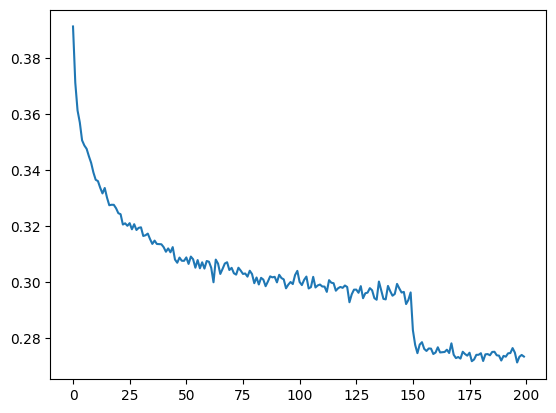

In [48]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [49]:
@torch.no_grad() # disable gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val':   (Xdev, Ydev),
        'test':  (Xte, Yte)
    }[split]
    emb = C[x]    
    embcat = emb.view(emb.shape[0], -1)    
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2    
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.887962818145752
val 2.049199104309082


In [50]:
# sample from the model

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:        
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # do the sampling
        idx = torch.multinomial( probs, num_samples=1).item()
        # shift the context window
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
            break
    print(''.join(itos[i] for i in out))

korberto.
gairon.
jalaia.
kirelin.
stafieg.
anniel.
myleilah.
ishan.
zailyn.
prezeyke.
mareley.
angelys.
elissia.
mesza.
tyana.
yxar.
jcristie.
raynah.
delania.
ailani.
